In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from autoplan.neighbors import TreeNNClassifier
from autoplan.token import OCamlTokenizer, PyretTokenizer, TokenType
from autoplan.trainer import ClassifierTrainer
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.dataset import TrainVal, RandomSplit, concat_datasets, set_random_seed

import dataclasses
import torch
from tqdm.auto import tqdm
from torch import nn
from torch.utils.data import Subset
import numpy as np
from scripts.rainfall_ingest import ingest_dataset, load_full_t1
import pandas as pd
from pickle_cache import PickleCache
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

pcache = PickleCache()
device = torch.device('cuda:7')

In [3]:
set_random_seed(0)

In [4]:
datasets = {
    'T1': load_full_t1(),
    'T1Acc': ingest_dataset('T1Acc', exclude=[], preprocess=True)
}

Skipped 16 programs
Skipped 2 programs


In [5]:
model_opts = {
    'model': nn.LSTM,
    'hidden_size': 512,
    'embedding_size': 128
}

k = 30
val_frac = 0.2

In [9]:
def make_cls(ds, tok):
    cls = TreeNNClassifier(ds, tok)
    return (cls, cls.compute_distance_matrix(cls.programs))

classifier = {
    'T1': pcache.get('nn_ocaml', lambda: make_cls(datasets['T1'], OCamlTokenizer())),
    'T1Acc': pcache.get('pyret_nn', lambda: make_cls(datasets['T1Acc'], PyretTokenizer()))
}

In [13]:
ks = [1, 3, 5, 10, 20]
nn_acc = {}
nn_eval = {}
for lang in ['T1', 'T1Acc']:    
    cls, mtx = classifier[lang]
    k_nn_evals = [cls.crossval(mtx, k=k_, folds=k, val_frac=val_frac) for k_ in ks]
    nn_evals = k_nn_evals[np.argmax([np.mean([evl.accuracy for evl in evals]) for evals in k_nn_evals])]
    nn_acc[lang] = pd.Series([evl.accuracy for evl in nn_evals])
    nn_eval[lang] = nn_evals

In [20]:
rnn_acc = {}
rnn_eval = {}
for lang in ['T1', 'T1Acc']:
    evals = ClassifierTrainer.crossval(
        datasets[lang], split=RandomSplit(datasets[lang]), k=k, epochs=100, val_frac=val_frac, model_opts=model_opts, 
        device=device, progress=True)
    rnn_acc[lang] = pd.Series([max([evl.accuracy for evl in val_eval]) for val_eval in evals['val_eval']])
    rnn_eval[lang] = evals['val_eval']

In [28]:
rnn_acc['T1'].mean()

0.7808641975308643

In [ ]:
rnn_top_eval = [val_eval[np.argmax([evl.accuracy for evl in val_eval])] for val_eval in rnn_eval['T1Acc']]

In [ ]:
evl = rnn_top_eval[4]
for idx in elv.incorrect():
    print 

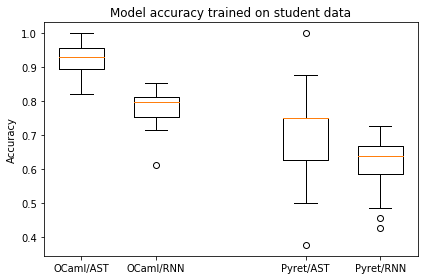

In [21]:
ax = plt.gca()
plt.boxplot([nn_acc['T1'], rnn_acc['T1']], positions=[1, 2], widths=0.6)
plt.boxplot([nn_acc['T1Acc'], rnn_acc['T1Acc']], positions=[4, 5], widths=0.6)
ax.set_xticklabels(['OCaml/AST', 'OCaml/RNN', 'Pyret/AST', 'Pyret/RNN'])
ax.set_ylabel('Accuracy')
ax.set_title('Model accuracy trained on student data')
plt.tight_layout()
plt.savefig('model-accuracy-student.png', dpi=150)

In [16]:
nn_acc_many = defaultdict(list)
val_fracs = [0.2, 0.4, 0.6, 0.8]
for lang in ['T1', 'T1Acc']:
    for val_frac in val_fracs:
        cls, mtx = classifier[lang]
        k_nn_evals = [cls.crossval(mtx, k=k_, folds=k, val_frac=val_frac) for k_ in ks]
        nn_evals = k_nn_evals[np.argmax([np.mean([evl.accuracy for evl in evals]) for evals in k_nn_evals])]
        nn_acc_many[lang].append([evl.accuracy for evl in nn_evals])

In [17]:
rnn_acc_many = defaultdict(list)
for lang in ['T1', 'T1Acc']:
    for val_frac in tqdm(val_fracs):
        evals = ClassifierTrainer.crossval(
            datasets[lang], split=RandomSplit(datasets[lang]), k=k, epochs=100, val_frac=val_frac, 
            model_opts=model_opts, device=device)
        rnn_acc_many[lang].append([max([evl.accuracy for evl in val_eval]) for val_eval in evals['val_eval']])

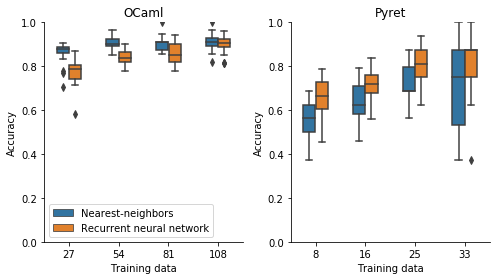

In [18]:
methods = {
    'Nearest-neighbors': nn_acc_many, 
    'Recurrent neural network': rnn_acc_many
}

_, axes = plt.subplots(ncols=2, figsize=(7, 4))
for ax, lang, size in zip(axes, ['T1', 'T1Acc'], [136, 42]):
    df = pd.DataFrame([{'Training data': int((1-f) * size), 'Accuracy': x, 'Method': method} 
                        for method in methods.keys() for f, l in zip(val_fracs, methods[method][lang]) for x in l])
    sns.boxplot(x='Training data', y='Accuracy', hue='Method', data=df, ax=ax, width=0.5)
    sns.despine()
    ax.legend(loc='lower left')
    ax.set_title('OCaml' if lang == 'T1' else 'Pyret')
    ax.set_ylim(0, 1.0)
    if lang == 'T1Acc':
        ax.legend().remove()
    
plt.tight_layout()
plt.savefig('student-data-only.pdf')

In [ ]:
df = pd.DataFrame([{'Training data': int((1-f) * size), 'Accuracy': x, 'Method': method} 
                        for method in methods.keys() for f, l in zip(val_fracs, methods[method]['T1Acc']) for x in l])

In [ ]:
df.groupby(['Method', 'Training data']).std().mean()

In [ ]:
def tree_size(t):
    return 1 + sum([tree_size(k) for k in t.children])
import numpy as np
np.mean([tree_size(t) for t in classifier['T1'].trees])

In [ ]:
np.mean([tree_size(t) for t in classifier['T1Acc'].trees])

In [ ]:
np.mean([len(item['program']) for item in datasets['T1'].dataset])

In [ ]:
np.mean([len(item['program']) for item in datasets['T1Acc'].dataset])